In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Two Point Boundary Value Problems

Consider a Poisson equation:
    
$$u^{\prime\prime} = f$$

on $[0, 1]$.  This is a second-order ODE, so it requires 2 boundary conditions.  Let's take:

\begin{align*}
u(0) &= a \\
u(1) &= b
\end{align*}

These are at opposite ends on the domain&mdash;this is not an initial value problem.  The methods we used thus far do not work on this.

Later we'll see how to apply _relaxation methods_ to this problem.  Now we'll consider the [_shooting method_](https://en.wikipedia.org/wiki/Shooting_method).

Let's rewrite this as a system defining:

\begin{align*}
y &= u \\
z &= u^\prime
\end{align*}

Let's take the left boundary conditions as:

\begin{align*}
y(0) &= a \\
z(0) &= \eta 
\end{align*}

What is $\eta$?  This is a parameter that we will adjust to make the solution yield $y(1) = b$ at the end of integration.  We'll all the solution for a particular value of $\eta$: $y^{(\eta)}(x)$.

Shooting algorithm:

  * Guess $\eta$
  * Iterate:
    * Integrate system to right boundary
    * Use secant method to zero $f(\eta) = b - y^{(\eta)}(1)$
    * Correct $\eta$

Example (from Pang):

$$u^{\prime\prime} = -\frac{1}{4} \pi^2 (u + 1)$$

with

\begin{align*}
u(0) &= 0 \\
u(1) &= 1
\end{align*}

This has the analytic solution:

$$u(x) = \cos(\pi x/2) + 2 \sin(\pi x / 2) - 1$$

Rewriting this system, we have:

\begin{align*}
y^\prime &= z \\
z^\prime &= -\frac{1}{4} \pi^2 (y + 1)
\end{align*}

Here's an implementation that uses RK4.

First the RHS function:

In [2]:
def rhs(y, z):
    """ RHS function.  Here y = u, z = u'"""
    
    dydx = z
    dzdx = -0.25 * np.pi**2 * (y + 1.0)

    return dydx, dzdx

Now the integrator:

In [10]:
def rk4(y0, eta0, rhs, xl=0.0, xr=1.0, n=100):
    """
    R-K 4 integration: y0 and eta0 are y(0) and z(0); rhs is the
    righthand side function xl and xr are the domain limits n
    is the number of integration points (including starting point)

    """
    
    # compute the step size
    h = (xr - xl) / (n - 1)

    y = np.zeros(n)
    z = np.zeros(n)

    # left boundary initialization
    y[0] = y0
    z[0] = eta0

    for m in range(n-1):
        dydx_1, dzdx_1 = rhs(y[m], z[m])
        dydx_2, dzdx_2 = rhs(y[m] + 0.5 * h * dydx_1, z[m] + 0.5 * h * dzdx_1)
        dydx_3, dzdx_3 = rhs(y[m] + 0.5 * h * dydx_2, z[m] + 0.5 * h * dzdx_2)
        dydx_4, dzdx_4 = rhs(y[m] + h * dydx_3, z[m] + h * dzdx_3)

        y[m+1] = y[m] + (h / 6.0) * (dydx_1 + 2.0 * dydx_2 + 2.0 * dydx_3 + dydx_4)
        z[m+1] = z[m] + (h / 6.0) * (dzdx_1 + 2.0 * dzdx_2 + 2.0 * dzdx_3 + dzdx_4)

    return y, z

and finally the driver:

In [11]:
def solve_bvp(ax=None):
    """shoot from x = 0 to x = 1.  We will do this by selecting a boundary
    value for z and use a secant method to adjust it until we reach the
    desired boundary condition at y(1)"""

    # domain size
    x_left = 0.0
    x_right = 1.0

    # desired right BC, y1(1)
    y_right_true = 1.0

    # number of integration points
    npts = 32

    # desired tolerance
    eps = 1.e-8

    # initial guess
    y_0 = 0.0   # this is the correct boundary condition a x = 0
    eta = 0.0   # this is what we will adjust to get the desired y1(1)

    # integrate
    y_old, z_old = rk4(y_0, eta, rhs, xl=0.0, xr=1.0, n=npts)

    if ax:
        x = np.linspace(0.0, 1.0, npts)
        ax.scatter(x, y_old, label="initial guess", marker="x")

    # new guess -- we don't have any info on how to compute this yet, so
    # just choose something
    eta_m1 = eta   # store the old guess
    eta = -1.0

    # Secant loop
    dy = 1000.0    # fail first time through

    # keep track of iteration for plotting
    iter = 1

    while dy > eps:

        # integrate
        y, z = rk4(y_0, eta, rhs, xl=0.0, xr=1.0, n=npts)

        if ax:
            ax.scatter(x, y, label=f"iteration {iter}", marker="x")

        # do a Secant method to correct.  Here eta = y2(0) -- our
        # control parameter.  We want to zero:
        #   f(eta) = y1_true(1) - y1^(eta)(1)

        # derivative (for Secant)
        dfdeta = ( (y_right_true - y_old[-1]) -
                   (y_right_true - y[-1]) ) / (eta_m1 - eta)

        # correction by f(eta) = 0 = f(eta_0) + dfdeta deta
        deta = -(y_right_true - y[-1]) / dfdeta

        # store the old guess and correct
        eta_m1 = eta
        eta += deta

        dy = abs(deta)

        y_old = y

        iter += 1
        
    return eta, y, z

Now we'll run it, making plots along the way.  We'll also show the analytic solution

In [12]:
def analytic(x):
    """ analytic solution """
    return np.cos(np.pi*x/2) + 2.0*np.sin(np.pi*x/2) - 1.0

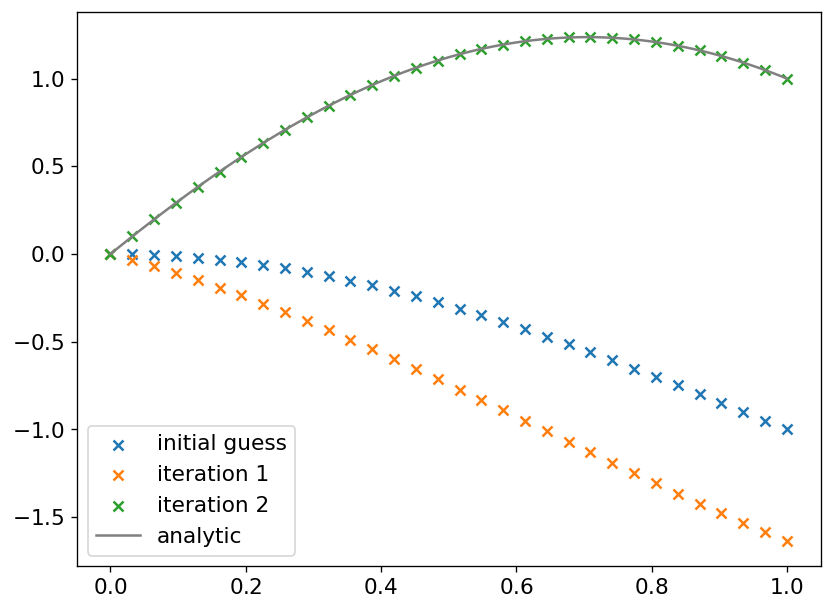

In [15]:
fig, ax = plt.subplots()

eta, y1, y2 = solve_bvp(ax)

x = np.linspace(0, 1, 100)
ax.plot(x, analytic(x), color="0.5", ls="-", label="analytic")
ax.legend()